In [ ]:
# Gabriel Schwarz, Paul Riedlsberger, Jakob Ladurner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sps
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from pathlib import Path
import re
import Lab2Functions as ekg

# Matplotlib etwas hübscher
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# --- Globale Parameter ---
FS = 598951/600  # Abtastrate berechnet aus Anzahl Samples / Dauer in Sekunden
print(f"Abtastrate: {FS:.2f} Hz")
REST_FILES = {
    "Paul":    "EKG_Ruhe_Paul.csv",
    "Gabriel": "EKG_Ruhe_Gabriel.csv",
    "Jakob":   "EKG_Ruhe_Jakob.csv",
}

EXERCISE_FILE = "EKG_Leistung_Paul.csv"

# Parameter für Filter
CUTOFF_ECG_HZ = 40       # sinnvolle Cutoff-Frequenz zum Entfernen von Hochfrequenzrauschen
BUTTER_ORDER = 4

# Parameter für R-Zacken-Detektion
R_HEIGHT_PER   = 0.4
R_DISTANCE_PER = 0.5


Abtastrate: 998.25 Hz


In [ ]:
def load_ecg_csv(filename, fs=FS):
    """
    Liest eine EKG-Datei ein und ergänzt eine Zeitspalte in Sekunden.

    Rückgabe:
        df : DataFrame mit Spalten ['index', 'value', 'time_s']
    """
    df = pd.read_csv(filename, sep=";")
    # index ist hier ein Sample-Index - es wir ein Zeitindex in s gemacht
    df["time_s"] = (df["index"] - df["index"].iloc[0]) / fs
    return df


def butter_lowpass_filter(signal, cutoff_hz=CUTOFF_ECG_HZ, fs=FS, order=BUTTER_ORDER):
    """
    Butterworth-Tiefpassfilter (filtfilt, also keine Phasenverschiebung).
    cutoff_hz: Grenzfrequenz in Hz
    """
    nyquist = fs / 2.0
    Wn = cutoff_hz / nyquist   # normierte Cutoff-Frequenz (0..1)
    b, a = sps.butter(order, Wn, btype="low", analog=False)
    filtered = sps.filtfilt(b, a, signal)
    return filtered, (b, a, Wn)


def detect_rwaves(ecg_values, time_vec,
                  height_per=0.4, distance_per=0.5):
    """
    Wrapper um die drei Funktionen aus Lab2Functions.py

    ecg_values : 1D-Array mit EKG-Signal (z.B. df['ecg_filtered'].values)
    time_vec   : Zeit als pandas Series (z.B. df['time_s'])
    """
    # Ableitung und rohe Peaks der Ableitung
    d_ECG, peaks_d_ecg = ekg.decg_peaks(ecg_values, time_vec)

    # Peaks der Ableitung mit Threshold & Mindestabstand
    Rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
        d_ECG, peaks_d_ecg, time_vec, height_per, distance_per
    )

    # R-Maxima im Originalsignal finden
    Rwave_t_obj = ekg.Rwave_peaks(ecg_values, d_ECG, Rwave_peaks_d_ecg, time_vec)

    
    import pandas as pd
    if isinstance(Rwave_t_obj, pd.DataFrame):
        t_r = Rwave_t_obj.iloc[:, 0].to_numpy()
    elif isinstance(Rwave_t_obj, pd.Series):
        t_r = Rwave_t_obj.to_numpy()
    else:
        t_r = np.asarray(Rwave_t_obj)

    return t_r, d_ECG, peaks_d_ecg, Rwave_peaks_d_ecg, threshold


def compute_hr_and_hrv(r_times,
                       min_hr_bpm=40.0,
                       max_hr_bpm=200.0,
                       ma_window=5):
    """
    Berechnet Herzfrequenz (HR) und HRV aus den R-Zacken-Zeitpunkten.

    - HR wird als 1/RR in bpm berechnet.
    - HRV = SDNN = Standardabweichung der RR-Intervalle in Millisekunden.
    - Ausreißer werden entfernt, indem nur HR zwischen min_hr_bpm und max_hr_bpm
      für HRV berücksichtigt werden.
    - Für Plots wird eine geglättete Herzfrequenz (moving average) zurückgegeben.

    Input:
        r_times    : 1D-Array mit R-Zacken-Zeitpunkten in Sekunden
        min_hr_bpm : minimale plausible Herzfrequenz
        max_hr_bpm : maximale plausible Herzfrequenz
        ma_window  : Fenstergröße für gleitenden Mittelwert (Anzahl Schläge)

    Output:
        hr_time    : Zeitpunkte (Sekunden) der gültigen HR-Werte
        hr_raw     : ungefilterte HR in bpm (nur gültige Werte)
        hr_smooth  : geglättete HR in bpm (gleitender Mittelwert)
        mean_hr    : mittlere HR in bpm (aus gültigen Werten)
        hrv_ms     : HRV (Std der RR-Intervalle) in Millisekunden
    """
    # RR-Intervalle in Sekunden (Abstand zwischen zwei R-Zacken)
    rr_intervals = np.diff(r_times)
    if len(rr_intervals) == 0:
        # zu wenige R-Zacken -> nichts berechenbar
        return np.array([]), np.array([]), np.array([]), np.nan, np.nan

    # Instantane HR in bpm
    hr_inst = 60.0 / rr_intervals
    hr_time_full = r_times[1:]  # HR gehört zum Intervall nach der ersten R-Zacke

    # Nur plausible HR-Werte berücksichtigen
    valid_mask = (hr_inst >= min_hr_bpm) & (hr_inst <= max_hr_bpm)
    if not np.any(valid_mask):
        return hr_time_full, hr_inst, hr_inst, np.nan, np.nan

    hr_valid = hr_inst[valid_mask]
    hr_time_valid = hr_time_full[valid_mask]
    rr_valid = rr_intervals[valid_mask]

    # HRV als Std der RR-Intervalle in Millisekunden (klassische SDNN)
    hrv_ms = np.std(rr_valid * 1000.0)

    # Mittlere HR
    mean_hr = np.mean(hr_valid)

    # einfache Glättung der HR über gleitenden Mittelwert
    if ma_window is not None and ma_window > 1 and len(hr_valid) >= ma_window:
        kernel = np.ones(ma_window) / ma_window
        hr_smooth = np.convolve(hr_valid, kernel, mode="same")
    else:
        hr_smooth = hr_valid.copy()

    return hr_time_valid, hr_valid, hr_smooth, mean_hr, hrv_ms

Geladene Signale:
- Laptop Akku (nicht am Netz): N=5000, fs=500 Hz
- Netzteil + Berührung (Metallgehäuse): N=2348, fs=500 Hz
- Netzteil (Netzbrummen): N=3891, fs=500 Hz


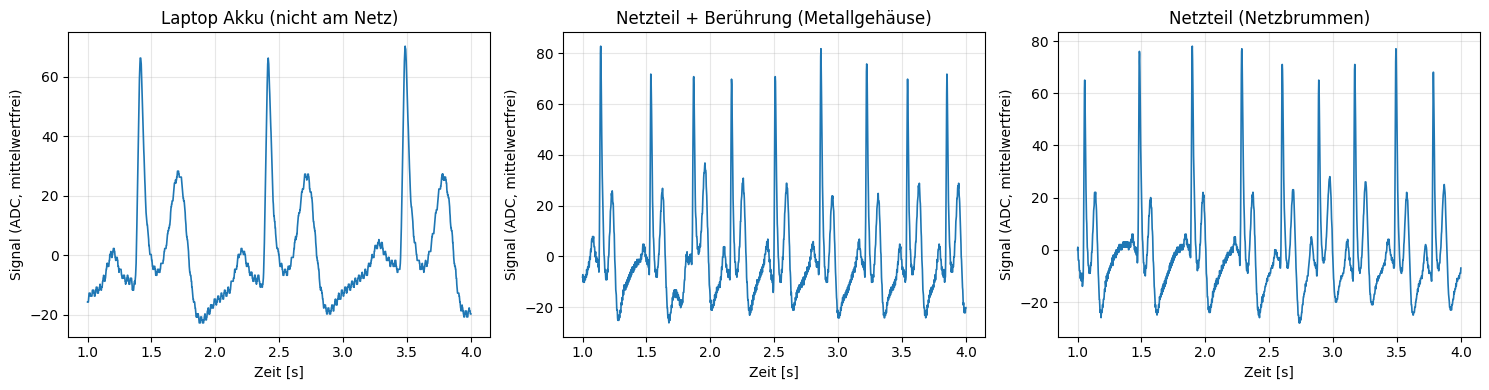

In [ ]:


DATA_DIR = Path(".")

FS_TXT = 500   # Abtastrate der TXT-Dateien
PLOT_FIRST_SECONDS = 10.0  # None = gesamte Aufnahme plotten

FILES = {
    "Laptop Akku (nicht am Netz)": "1_Test_Zeitstempel.txt",
    "Netzteil + Berührung (Metallgehäuse)": "Vergleich_Berührung.txt",
    "Netzteil (Netzbrummen)": "Vergleich_Netzbrummen.txt",
}


def load_signal(path: Path) -> np.ndarray:
    """
    Robustes Einlesen:
    - TXT / CSV
    - ; , whitespace
    - Spezialfall: '295/t0' -> extrahiert 295
    """
    lines = path.read_text(errors="ignore").splitlines()
    if len(lines) == 0:
        return np.array([], dtype=float)

    # Spezialfall Zeitstempel "295/t0"
    if any("/t" in line for line in lines[:50]):
        values = []
        for line in lines:
            line = line.strip()
            if not line:
                continue
            left = line.split("/")[0]
            try:
                values.append(float(left))
            except ValueError:
                continue
        return np.array(values, dtype=float)

    # CSV / TXT mit Trennzeichen
    for sep in [";", ","]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python", header=None)
            col = df.iloc[:, 1] if df.shape[1] >= 2 else df.iloc[:, 0]
            s = pd.to_numeric(col, errors="coerce").dropna()
            return s.to_numpy(dtype=float)
        except Exception:
            pass

    # Fallback: whitespace
    df = pd.read_csv(path, delim_whitespace=True, header=None)
    col = df.iloc[:, 1] if df.shape[1] >= 2 else df.iloc[:, 0]
    s = pd.to_numeric(col, errors="coerce").dropna()
    return s.to_numpy(dtype=float)


def make_time_axis(n, fs):
    return np.arange(n) / fs


def detrend(y):
    """Mittelwert entfernen"""
    y = np.asarray(y, dtype=float)
    if len(y) == 0:
        return y
    return y - np.mean(y)


# Daten laden
signals = {}

for title, fname in FILES.items():
    p = DATA_DIR / fname
    y = load_signal(p)
    fs = FS_TXT
    t = make_time_axis(len(y), fs)

    if PLOT_FIRST_SECONDS is not None and len(y) > 0:
        n_keep = min(int(PLOT_FIRST_SECONDS * fs), len(y))
        y = y[:n_keep]
        t = t[:n_keep]

    signals[title] = {"t": t, "y": y, "fs": fs}

print("Geladene Signale:")
for k, v in signals.items():
    print(f"- {k}: N={len(v['y'])}, fs={v['fs']} Hz")


# 1×3 Vergleichsplot (Variante B)
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

MAX_POINTS = 2000  # Downsampling für flüssige Darstellung

for ax, (title, d) in zip(axs, signals.items()):
    t = d["t"]
    y = detrend(d["y"])

    mask = (t >= 1.0) & (t <= 4.0)
    t = t[mask]
    y = y[mask]

    # Downsampling
    if len(y) > MAX_POINTS:
        step = len(y) // MAX_POINTS
        t = t[::step]
        y = y[::step]

    ax.plot(t, y, linewidth=1.2)

 
    ax.set_title(title)
    ax.set_xlabel("Zeit [s]")
    ax.set_ylabel("Signal (ADC, mittelwertfrei)")
    ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()


In [ ]:
# Ruhe-EKG aller Teilnehmer einlesen & verarbeiten

rest_results = {}  # hier speichern wir alle relevanten Infos pro Person

for name, fname in REST_FILES.items():
    # Rohdaten laden
    df = load_ecg_csv(fname, fs=FS)

    # EKG filtern
    df["ecg_filtered"], _ = butter_lowpass_filter(
        df["value"].values, cutoff_hz=CUTOFF_ECG_HZ, fs=FS
    )

    # Zeit als Series
    time_series = df["time_s"]

    # R-Zacken detektieren
    r_times, d_ECG, peaks_d_ecg, Rpeaks_d_ecg, thr = detect_rwaves(
        df["ecg_filtered"].values, time_series
    )

    # HR & HRV berechnen
    hr_time, hr_raw, hr_smooth, mean_hr, hrv_ms = compute_hr_and_hrv(
        r_times,
        min_hr_bpm=40.0,
        max_hr_bpm=200.0,
        ma_window=5
    )

    rest_results[name] = {
        "df": df,
        "r_times": r_times,
        "d_ECG": d_ECG,
        "peaks_d_ecg": peaks_d_ecg,
        "Rpeaks_d_ecg": Rpeaks_d_ecg,
        "threshold_d_ecg": thr,
        "hr_time": hr_time,
        "hr_raw": hr_raw,
        "hr_smooth": hr_smooth,
        "HR_mean_bpm": mean_hr,
        "HRV_ms": hrv_ms,
    }

# Übersichtstabelle für die Ruhe-Messungen
rest_summary = pd.DataFrame.from_dict(
    {
        name: {
            "HR_mean_bpm": vals["HR_mean_bpm"],
            "HRV_ms": vals["HRV_ms"],
        }
        for name, vals in rest_results.items()
    },
    orient="index"
)

rest_summary

,HR_mean_bpm,HRV_ms
Paul,66.600783,85.095150
Gabriel,64.746882,75.540721
Jakob,87.918772,33.412433


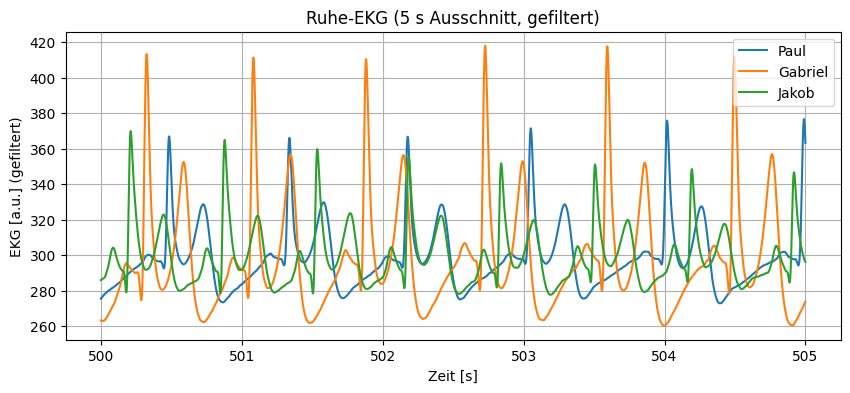

In [ ]:
# 5 Sekunden des gefilterten Ruhe-EKG plotten

# beliebigen Zeitbereich wählen (z.B. von 10s bis 15s)
t_start = 500.0
t_window = 5.0
t_end = t_start + t_window

fig, ax = plt.subplots()
for name, res in rest_results.items():
    df = res["df"]
    mask = (df["time_s"] >= t_start) & (df["time_s"] < t_end)
    ax.plot(df["time_s"][mask], df["ecg_filtered"][mask], label=name)

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("EKG [a.u.] (gefiltert)")
ax.set_title("Ruhe-EKG (5 s Ausschnitt, gefiltert)")
ax.legend()
plt.show()


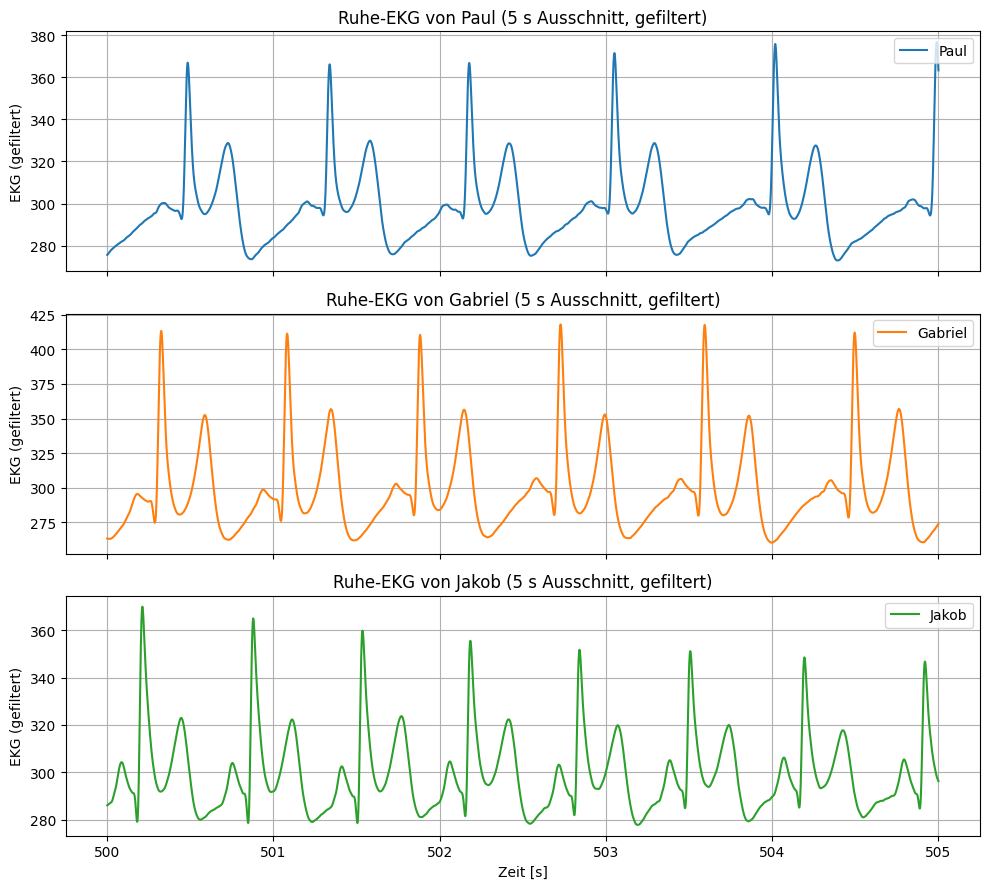

In [6]:
t_start = 500.0
t_window = 5.0
t_end = t_start + t_window

colors = {
    "Paul": "tab:blue",
    "Gabriel": "tab:orange",
    "Jakob": "tab:green"
}

fig, axs = plt.subplots(len(rest_results), 1, figsize=(10, 3*len(rest_results)), sharex=True)

for ax, (name, res) in zip(axs, rest_results.items()):
    df = res["df"]
    mask = (df["time_s"] >= t_start) & (df["time_s"] < t_end)

    # Farbe anhand des Namens setzen
    ax.plot(
        df["time_s"][mask],
        df["ecg_filtered"][mask],
        label=name,
        color=colors.get(name, "black")   # fallback, falls Name nicht im Dict
    )

    ax.set_ylabel("EKG (gefiltert)")
    ax.set_title(f"Ruhe-EKG von {name} (5 s Ausschnitt, gefiltert)")
    ax.legend(loc="upper right")

axs[-1].set_xlabel("Zeit [s]")
plt.tight_layout()
plt.show()


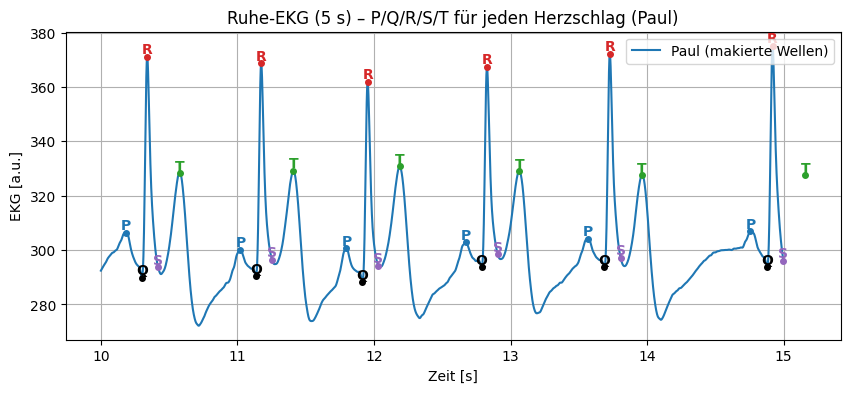

In [ ]:
#Für eine Person (z.B. Paul) P/Q/R/S/T für JEDE Welle markieren 

person_for_detail = "Paul"
res = rest_results[person_for_detail]
df = res["df"]
r_times = res["r_times"]

# Ausschnitt wählen
t_start = 10.0
t_window = 5.0
t_end = t_start + t_window

mask = (df["time_s"] >= t_start) & (df["time_s"] < t_end)

t_all = df["time_s"].to_numpy()
y_all = df["ecg_filtered"].to_numpy()

fig, ax = plt.subplots()
ax.plot(df["time_s"][mask], df["ecg_filtered"][mask],
        label=f"{person_for_detail} (makierte Wellen)")

# Feste Farben pro Welle
WAVE_COLORS = {
    "P": "#1f77b4",   # blau
    "Q": "#000000",   # schwarz
    "R": "#d62728",   # rot
    "S": "#9467bd",   # violett
    "T": "#2ca02c",   # grün
}


# Hilfsfunktion: lokalen Peak im Zeitfenster finden
def find_peak(kind, center_time, t_before, t_after):
    start_t = center_time + t_before
    end_t   = center_time + t_after

    start_idx = np.searchsorted(t_all, start_t)
    end_idx   = np.searchsorted(t_all, end_t)

    if end_idx <= start_idx:
        return None, None

    segment = y_all[start_idx:end_idx]

    if kind == "max":
        idx_local = np.argmax(segment)
    else:
        idx_local = np.argmin(segment)

    idx = start_idx + idx_local
    return t_all[idx], y_all[idx]

# Alle R-Zacken im Fenster
r_times_win = [t for t in r_times if t_start <= t < t_end]

for r_ref in r_times_win:

    # R-Wert
    t_R = r_ref
    y_R = np.interp(t_R, t_all, y_all)

    # typische Zeitfenster relativ zur R-Zacke
    t_P, y_P = find_peak("max", t_R, -0.25, -0.05)
    t_Q, y_Q = find_peak("min", t_R, -0.06, -0.01)
    t_S, y_S = find_peak("min", t_R,  0.01,  0.08)
    t_T, y_T = find_peak("max", t_R,  0.15,  0.40)


    # Beschriftungsfunktion
    def label(letter, tx, ty):
        if tx is None or ty is None:
            return
        color = WAVE_COLORS.get(letter, "black")
        ax.plot(tx, ty, "o", color=color, markersize=4)
        ax.text(
            tx, ty, letter,
            color=color,
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

    # Alle Wellen labeln
    label("P", t_P, y_P)
    label("Q", t_Q, y_Q)
    label("R", t_R, y_R)
    label("S", t_S, y_S)
    label("T", t_T, y_T)

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("EKG [a.u.]")
ax.set_title(f"Ruhe-EKG (5 s) – P/Q/R/S/T für jeden Herzschlag ({person_for_detail})")
ax.legend(loc = "upper right")
plt.show()


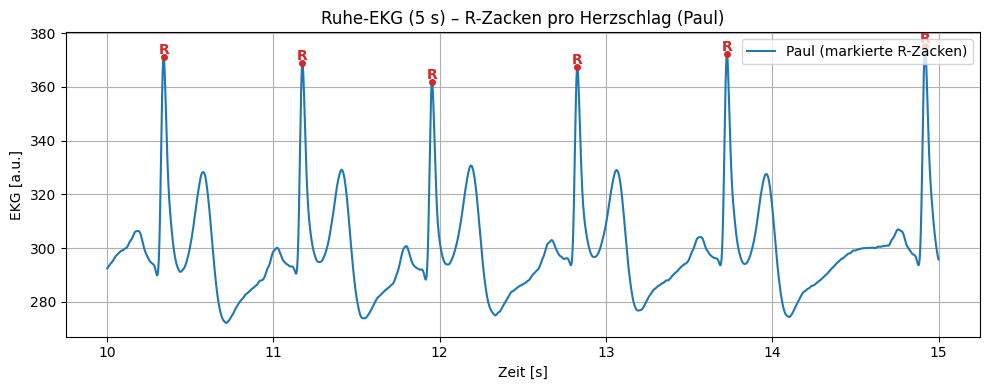

In [ ]:
#Für eine Person (z.B. Paul) NUR die R-Zacken markieren

person_for_detail = "Paul"
res = rest_results[person_for_detail]
df = res["df"]
r_times = res["r_times"]

# Ausschnitt wählen
t_start = 10.0
t_window = 5.0
t_end = t_start + t_window

mask = (df["time_s"] >= t_start) & (df["time_s"] < t_end)

t_all = df["time_s"].to_numpy()
y_all = df["ecg_filtered"].to_numpy()

fig, ax = plt.subplots()
ax.plot(df["time_s"][mask], df["ecg_filtered"][mask],
        label=f"{person_for_detail} (markierte R-Zacken)")

# Farbe nur für R-Wellen
R_COLOR = "#d62728"   # rot

# Hilfsfunktion zum Beschriften der R-Zacken
def label_R(tx, ty):
    if tx is None or ty is None:
        return
    ax.plot(tx, ty, "o", color=R_COLOR, markersize=4)
    ax.text(
        tx, ty, "R",
        color=R_COLOR,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Alle R-Zacken im Fenster
r_times_win = [t for t in r_times if t_start <= t < t_end]

for t_R in r_times_win:
    # R-Wert aus dem gefilterten Signal (interpoliert)
    y_R = np.interp(t_R, t_all, y_all)
    label_R(t_R, y_R)

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("EKG [a.u.]")
ax.set_title(f"Ruhe-EKG (5 s) – R-Zacken pro Herzschlag ({person_for_detail})")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
# HeartRateData einlesen 

try:
    hr_class = pd.read_csv("HeartRateData.csv")
except FileNotFoundError:
    print("HeartRateData.csv nicht gefunden - bitte Datei aus OneDrive herunterladen")
    hr_class = None

hr_class

if hr_class is not None:

    # Gruppennamen für Titel
    GROUP_NAME = "JPG_B1" 

    # Histogramm mittlere Herzfrequenz
    fig, ax = plt.subplots()
    sexes = hr_class["Sex"].unique()
    for s in sexes:
        vals = hr_class.loc[hr_class["Sex"] == s, "HR_mean"]
        ax.hist(vals, alpha=0.5, label=str(s))
    ax.set_xlabel("Mittlere Herzfrequenz [bpm]")
    ax.set_ylabel("Anzahl Teilnehmer")
    ax.set_title(f"Verteilung HR_mean in der Klasse - {GROUP_NAME}")
    ax.legend(title="Geschlecht")
    plt.show()

    # Histogramm HRV
    fig, ax = plt.subplots()
    for s in sexes:
        vals = hr_class.loc[hr_class["Sex"] == s, "HRV"]
        ax.hist(vals, alpha=0.5, label=str(s))
    ax.set_xlabel("Herzfrequenzvariabilität [bpm] (Std)")
    ax.set_ylabel("Anzahl Teilnehmer")
    ax.set_title(f"Verteilung HRV in der Klasse - {GROUP_NAME}")
    ax.legend(title="Geschlecht")
    plt.show()


HeartRateData.csv nicht gefunden - bitte Datei aus OneDrive herunterladen


In [ ]:
# EKG-Daten des Belastungs-Experiments einlesen

exercise_df = load_ecg_csv(EXERCISE_FILE, fs=FS)
exercise_df["ecg_filtered"], _ = butter_lowpass_filter(
    exercise_df["value"].values, cutoff_hz=CUTOFF_ECG_HZ, fs=FS
)

# Zeit als Series
time_series_ex = exercise_df["time_s"]

# R-Zacken finden
r_times_ex, d_ECG_ex, peaks_d_ex, Rpeaks_d_ex, thr_ex = detect_rwaves(
    exercise_df["ecg_filtered"].values, time_series_ex
)

#HR & HRV berechnen (leicht geglättet über ma_window)
hr_time_ex, hr_raw_ex, hr_filt_ex, mean_hr_ex, hrv_rr_ex = compute_hr_and_hrv(
    r_times_ex,
    min_hr_bpm=40.0,
    max_hr_bpm=200.0,
    ma_window=5     # leicht geglättet
)

# Zusätzliche Glättung nur für die Darstellung
window_length = 31
max_len = len(hr_filt_ex)
kernel = np.ones(10) / 10 

if max_len < 5:
    # zu wenige Punkte, dann gar nicht glätten
    hr_smooth_ex = hr_filt_ex.copy()
else:
    if window_length > max_len:
        window_length = max_len if max_len % 2 == 1 else max_len - 1
    hr_smooth_ex = savgol_filter(hr_filt_ex, window_length=window_length, polyorder=3)


print(
    f"Belastungsexperiment: mittlere HR = {mean_hr_ex:.1f} bpm, "
    f"HRV (RR) = {hrv_rr_ex:.1f} ms"
)

Belastungsexperiment: mittlere HR = 119.6 bpm, HRV (RR) = 129.6 ms


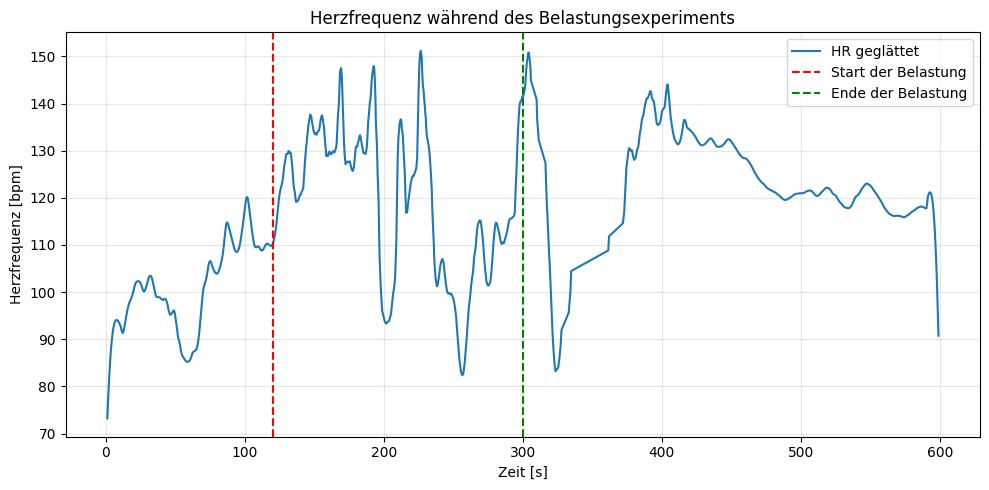

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

# HR-Kurve
ax.plot(hr_time_ex, hr_smooth_ex, label="HR geglättet")

# Vertikale Linien für Start und Ende der Übung
ax.axvline(x=120, color='r', linestyle='--', linewidth=1.5, label='Start der Belastung')
ax.axvline(x=300, color='g', linestyle='--', linewidth=1.5, label='Ende der Belastung')

# Achsenbeschriftungen und Titel
ax.set_xlabel("Zeit [s]")
ax.set_ylabel("Herzfrequenz [bpm]")
ax.set_title("Herzfrequenz während des Belastungsexperiments")

# Grid optional
ax.grid(True, alpha=0.3)

# Legende
ax.legend()

plt.tight_layout()
plt.show()


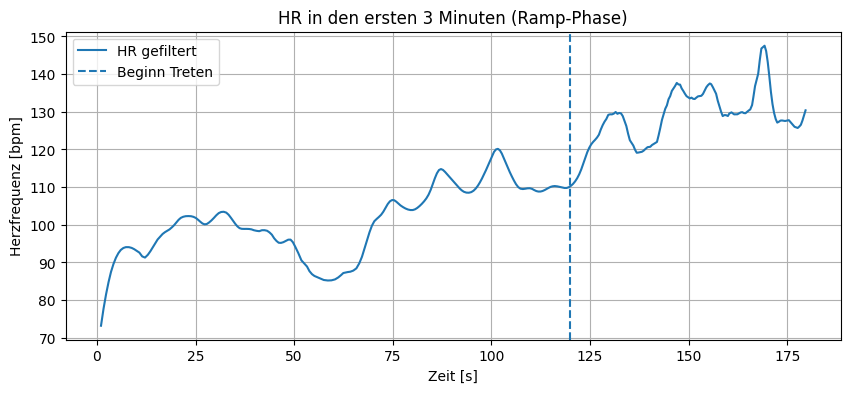

Im Bericht beschreibst du hier z.B.:
- wie die HR ansteigt
- warum Start der Übung und HR-Anstieg nicht exakt gleichzeitig sind (Verzögerung im Kreislauf).


In [ ]:
# Zeit (in Sekunden), zu der das Treten begonnen hat
t_start_exercise = 120.0 

t0 = 0.0
t1 = 180.0  # erste 3 Minuten

mask_ramp = (hr_time_ex >= t0) & (hr_time_ex <= t1)

fig, ax = plt.subplots()
ax.plot(hr_time_ex[mask_ramp], hr_smooth_ex[mask_ramp], label="HR gefiltert")
ax.axvline(t_start_exercise, linestyle="--", label="Beginn Treten")

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("Herzfrequenz [bpm]")
ax.set_title("HR in den ersten 3 Minuten (Ramp-Phase)")
ax.legend()
plt.show()

print("Im Bericht beschreibst du hier z.B.:")
print("- wie die HR ansteigt")
print("- warum Start der Übung und HR-Anstieg nicht exakt gleichzeitig sind (Verzögerung im Kreislauf).")


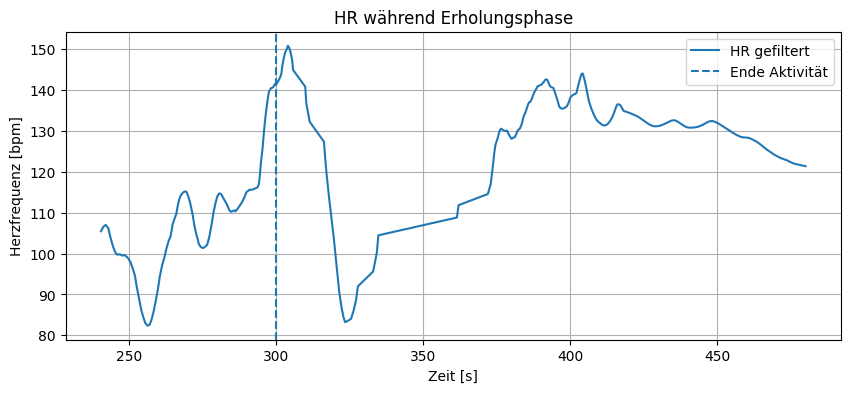

Im Bericht beantwortest du:
- kommt die HR wieder zum Ruhepuls zurück und wie lange dauert das?
- warum dauert das so lange?
- warum Athleten typischerweise eine schnellere Erholung haben?


In [ ]:
# Zeitpunkt in Sekunden, zu dem das Treten gestoppt wurde
t_stop_exercise = 300.0 

t_rec_start = t_stop_exercise - 60.0   # 1 Minute davor
t_rec_end   = t_stop_exercise + 180.0  # 3 Minuten danach

mask_rec = (hr_time_ex >= t_rec_start) & (hr_time_ex <= t_rec_end)

fig, ax = plt.subplots()
ax.plot(hr_time_ex[mask_rec], hr_smooth_ex[mask_rec], label="HR gefiltert")
ax.axvline(t_stop_exercise, linestyle="--", label="Ende Aktivität")

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("Herzfrequenz [bpm]")
ax.set_title("HR während Erholungsphase")
ax.legend()
plt.show()

print("Im Bericht beantwortest du:")
print("- kommt die HR wieder zum Ruhepuls zurück und wie lange dauert das?")
print("- warum dauert das so lange?")
print("- warum Athleten typischerweise eine schnellere Erholung haben?")


Gesamter Energieverbrauch im Belastungsexperiment: 378.6 kJ (≈ 90.5 kcal)
Mittlerer Energieverbrauch: 38.0 kJ/min


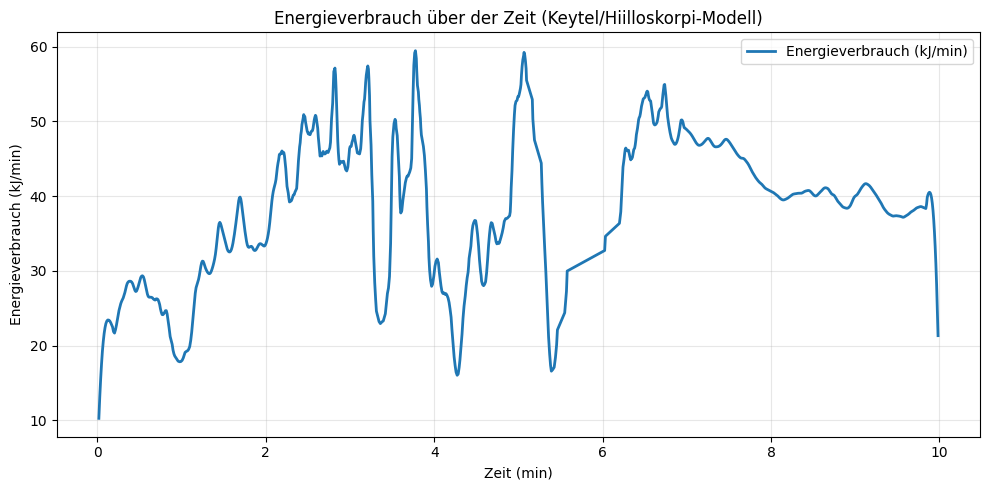

In [ ]:

# Parameter der Versuchsperson
body_mass_kg = 72.0   # Körpermasse in kg
age_years    = 24.0   # Alter in Jahren
sex          = "M"    # oder "F"
  


def energy_expenditure_hiilloskorpi(hr_bpm, body_mass_kg, age_years, sex):
    """
    Schätzt den Energieverbrauch nach Keytel et al. (2005) in kJ/min.
    Wird häufig im Kontext Hiilloskorpi verwendet.

    Parameter
    ---------
    hr_bpm       : Array der Herzfrequenzen in bpm
    body_mass_kg : Körpergewicht in kg
    age_years    : Alter in Jahren
    sex          : "M" oder "F"

    Rückgabe
    --------
    EE_kJ_per_min : Array des Energieverbrauchs in kJ/min
    """
    hr_bpm = np.asarray(hr_bpm, dtype=float)

    gender = 1 if sex.upper().startswith("M") else 0  # 1 = männlich, 0 = weiblich

    EE_kJ_per_min = (
        gender * (-55.0969 + 0.6309 * hr_bpm + 0.1988 * body_mass_kg + 0.2017 * age_years)
        + (1 - gender) * (-20.4022 + 0.4472 * hr_bpm - 0.1263 * body_mass_kg + 0.074 * age_years)
    )

    return np.maximum(EE_kJ_per_min, 0.0)  # negative Werte verhindern


# Energieverbrauch über Zeit aus der HR-Kurve des Belastungsversuchs

# EE pro Minute für jede HR-Messung (kJ/min)
EE_kJ_per_min_series = energy_expenditure_hiilloskorpi(
    hr_smooth_ex, body_mass_kg, age_years, sex
)

# Zeitabstände in Minuten
dt_min = np.diff(hr_time_ex, prepend=hr_time_ex[0]) / 60.0

# Gesamtenergie in kJ und kcal
EE_total_kJ = np.sum(EE_kJ_per_min_series * dt_min)
EE_total_kcal = EE_total_kJ * 0.239006  # kJ → kcal

print(f"Gesamter Energieverbrauch im Belastungsexperiment: "
      f"{EE_total_kJ:.1f} kJ (≈ {EE_total_kcal:.1f} kcal)")

# mittlerer Energieverbrauch
mean_EE_kJ_per_min = np.sum(EE_kJ_per_min_series * dt_min) / np.sum(dt_min)
print(f"Mittlerer Energieverbrauch: {mean_EE_kJ_per_min:.1f} kJ/min")


# Plot des Energieverbrauchs über der Zeit

# Zeitachse in Minuten
time_min = hr_time_ex / 60.0

plt.figure(figsize=(10, 5))
plt.plot(time_min, EE_kJ_per_min_series, label="Energieverbrauch (kJ/min)", linewidth=2)

plt.title("Energieverbrauch über der Zeit (Keytel/Hiilloskorpi-Modell)")
plt.xlabel("Zeit (min)")
plt.ylabel("Energieverbrauch (kJ/min)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Umrechnungen: Joule, kcal, Rittersport, Bier, Anteil Tagesbedarf

EE_total_units = EE_total_kcal
EE_total_J = EE_total_kcal * 4184.0  # 1 kcal = 4184 J

KCAL_PER_RITTERSPORT = 550.0  
KCAL_PER_BEER_05L    = 200.0  

n_ritter = EE_total_kcal / KCAL_PER_RITTERSPORT
n_beer   = EE_total_kcal / KCAL_PER_BEER_05L

# Täglicher Kalorienbedarf
daily_need_kcal = 2200.0  

fraction_of_daily = EE_total_kcal / daily_need_kcal

print(f"Gesamter Energieverbrauch (angenommen in kcal): {EE_total_kcal:.1f} kcal")
print(f"Das entspricht etwa {n_ritter:.2f} Rittersport-Tafeln")
print(f"oder ca. {n_beer:.2f} Bier (0.5L)")
print(f"Anteil am täglichen Bedarf: {fraction_of_daily*100:.1f} % (bei {daily_need_kcal:.0f} kcal/Tag)")


Gesamter Energieverbrauch (angenommen in kcal): 90.5 kcal
Das entspricht etwa 0.16 Rittersport-Tafeln
oder ca. 0.45 Bier (0.5L)
Anteil am täglichen Bedarf: 4.1 % (bei 2200 kcal/Tag)


Geschlechtsverteilung:
Geschlecht
w    15
m    13
Name: count, dtype: int64


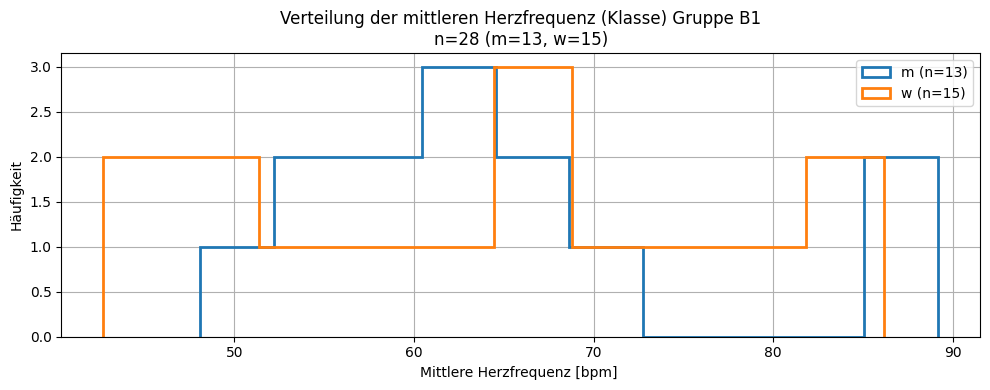

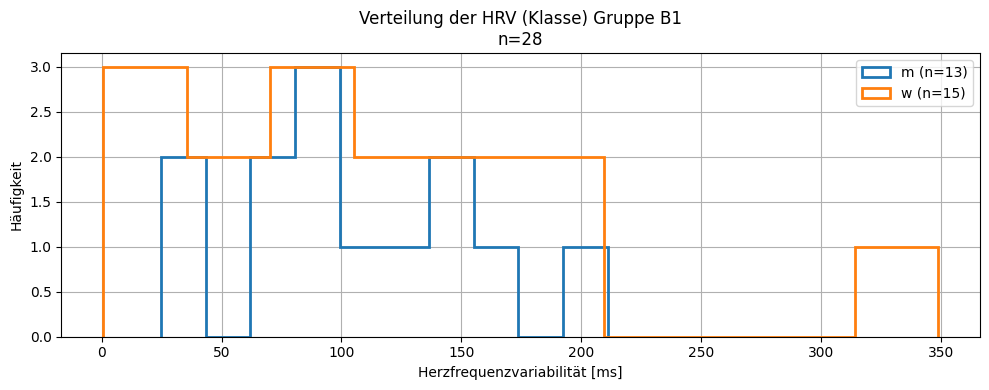

In [ ]:
# CSV einlesen

df = pd.read_csv("HeartRateData - Hoja 1.csv")

# Spalten umbenennen
df = df.rename(columns={
    "Herzfrequenz [bpm]": "HR_mean",
    "Herzfrequenzvariabilitaet [ms]": "HRV",
    "Geschlecht m/w/d": "Geschlecht"
})

# Numerische Spalten konvertieren
df["HR_mean"] = pd.to_numeric(df["HR_mean"], errors="coerce")
df["HRV"] = pd.to_numeric(df["HRV"], errors="coerce")
# Geschlecht bereinigen
df["Geschlecht"] = (
    df["Geschlecht"]
    .astype(str)
    .str.strip()                       # sichtbare Leerzeichen
    .str.replace(r"\s+", "", regex=True)  # unsichtbare Whitespaces
    .str.lower()
)

# Sicherheitscheck
print("Geschlechtsverteilung:")
print(df["Geschlecht"].value_counts())


# Zählungen
n_total = len(df)
n_m = (df["Geschlecht"] == "m").sum()
n_w = (df["Geschlecht"] == "w").sum()

gruppenname = "Gruppe B1" 


# Histogramm: mittlere Herzfrequenz
plt.figure()
for sex in ["m", "w"]:
    subset = df[df["Geschlecht"] == sex]
    plt.hist(
    subset["HR_mean"],
    bins=10,
    histtype="step",
    linewidth=2,
    label=f"{sex} (n={len(subset)})"
)


plt.xlabel("Mittlere Herzfrequenz [bpm] ")
plt.ylabel("Häufigkeit")
plt.title(
    f"Verteilung der mittleren Herzfrequenz (Klasse) {gruppenname}\n"
    f"n={n_total} (m={n_m}, w={n_w})"
)
plt.legend()
plt.tight_layout()
plt.savefig("HR_mean_Histogramm.png")
plt.show()

# Histogramm: Herzfrequenzvariabilität
plt.figure()
for sex in ["m", "w"]:
    subset = df[df["Geschlecht"] == sex]
    plt.hist(
    subset["HRV"],
    bins=10,
    histtype="step",   # 👈 nur Umrisse
    linewidth=2,
    label=f"{sex} (n={len(subset)})"
)


plt.xlabel("Herzfrequenzvariabilität [ms]")
plt.ylabel("Häufigkeit")
plt.title(
    f"Verteilung der HRV (Klasse) {gruppenname}\n"
    f"n={n_total}"
)
plt.legend()
plt.tight_layout()
plt.savefig("HRV_Histogramm.png")
plt.show()
